In [1]:
!pip install -qU transformers accelerate bitsandbytes
!pip install -qU langchain langchain-core langchain-community langchain-text-splitters
!pip install -qU langchain_huggingface
!pip install -qU faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 696.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import json
import re
import os
import torch
from sentence_transformers import SentenceTransformer
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from transformers import pipeline
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_huggingface import HuggingFacePipeline

from sentence_transformers import util

2025-07-25 10:44:13.412614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753440253.616126      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753440253.683438      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Class RAG have some module for retriever documents

In [3]:
from typing import Any, List, Union
# from langchain_huggingface import HuggingFaceEmbeddings
from langchain.docstore.document import Document

import os
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
class RAG_answer_package_viettel:
    def __init__(self,
                 name_model_llm : str = "vilm/vinallama-7b-chat", 
                 #the model name LLM main for answer the user question
                 name_model_embedding : str = "keepitreal/vietnamese-sbert",#the model use for embedding context to vector this model save vector store and load vector store for main model"""
                 data_path_for_RAG : Union[str, List[str]] = None,
                 # data path (Json folder) but at there i have 2 folder need process
                 vector_store_path : str = None,
                 # folder path vector store saved by FAISS
                 llm : Any = None,
                 prompt_template : Any = None):
        self.name_model_llm = name_model_llm
        self.name_model_embedding = name_model_embedding
        self.data_path_for_RAG = data_path_for_RAG
        self.vector_store_path = vector_store_path
        
        self.llm = llm
        """the main model llm need define out come class"""
        self.prompt_template = prompt_template
        """the prompt"""
        self.model_embedding = HuggingFaceEmbeddings(
                                                    model_name=self.name_model_embedding,
                                                    model_kwargs = {"device" : device},
                                                    show_progress=True
                                                   )
        self.model_find_relevant_context=SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
        
        self.vector_store = None
        self.prompt = None
        # load vector store when build vector store done
    def build_vector_store(self):
        text_from_json=[]
        def case_for_folder_one(folde_path):
            """if data path just only a folder
               compare each file json and get conversation
               the conversation struction in json like this   
                {   "conversations" : 
                    [
                        {
                            "role" : "user",
                            "content" : "Question",
                        },
                        {
                            "role" : "assistant",
                            "content" : "Answer",
                        }
                    ]
                }"""
            if not os.path.exists(folde_path):
                raise FileNotFoundError(f"DATA PATH JSON NOT FOUND PLEASE CHECK {folde_path}")
        
            for short_name_file_json in os.listdir(folde_path):
                file_path_json = os.path.join(folde_path , short_name_file_json)
                
                with open(file_path_json , "r", encoding = "utf-8") as f:
                    contents_file_json = json.load(f) # load json
                    
                for content in contents_file_json:
                    a_conversation = str(f'Q: {content["conversations"][0]["content"]}\nA: {content["conversations"][1]["content"]}')
                    """get content of conversation on json file"""
                    text_from_json.append(a_conversation)
        def case_for_folder_two(folder_path):
            """if data path have two folder
               compare each file json and get conversation or content
               the conversation struction in json like those
                case:2
                {
                    "text": "content",
                    "metadata": 
                    {
                        "url": "URL package",
                        "title": "package name",
                        "section": "Ưu đãi"
                    }
                }
                """
            if not os.path.exists(folde_path):
                raise FileNotFoundError(f"DATA PATH JSON NOT FOUND PLEASE CHECK {folde_path}")
        
            for short_name_file_json in os.listdir(folde_path):
                file_path_json = os.path.join(folde_path , short_name_file_json)
                
                with open(file_path_json , "r", encoding = "utf-8") as f:
                    contents_file_json = json.load(f) # load json
                    
                for content in range(len(contents_file_json)):
                    a_conten = f'{contents[i]["metadata"]["section"]} của gói cước {contents[i]["metadata"]["title"]} {contents[i]["text"]}'
                    """get content of conversation on json file"""
                    text_from_json.append(a_conten)   
        if isinstance(self.data_path_for_RAGRAG , str):
            case_for_folder_one(self.data_path_for_RAGRAG)

        elif isinstance(self.data_path_for_RAGRAG , list):
            case_for_folder_one(self.data_path_for_RAGRAG[0])
            case_for_folder_two(self.data_path_for_RAGRAG[1])
        documents = [Document(page_content=text) for text in text_from_json]
        vector_db = FAISS.from_documents(documents , self.model_embedding)
        vector_db.save_local(self.vector_store_path)

    def load_vector_store(self):
        vector_store = FAISS.load_local(self.vector_store_path,
                                             self.model_embedding,
                                             allow_dangerous_deserialization = True
                                            )
        return vector_store
    def create_prompt(self,flag,context,question):
        if flag==1:
            self.prompt_template = f"""<|im_start|>system
Bạn là một trợ lý AI hữu ích tên là TUNGLLAMA. Hãy chỉ dựa vào thông tin trong ngữ cảnh bên dưới để trả lời câu hỏi một cách chính xác, ngắn gọn và không lặp lại. Nếu không tìm thấy câu trả lời trong ngữ cảnh, hãy trả lời "Tôi không tìm thấy thông tin trong ngữ cảnh".
<|im_end|>
<|im_start|>user
Ngữ cảnh:
{context}

Câu hỏi:
{question}
<|im_end|>
<|im_start|>assistant
"""
            return PromptTemplate(template=self.prompt_template, input_variables=["context" , "question"])
        elif flag==0:
            self.prompt_template= f"""<|im_start|>system
Bạn là một trợ lí AI tên là TungLlama. Hãy trả lời người dùng một cách chính xác.
<|im_end|>
<|im_start|>user
{question}<|im_end|>
<|im_start|>assistant
"""
            return PromptTemplate(template=self.prompt_template, input_variables=["question"])

    def get_model_tokenizer(self):
        nf4_config = BitsAndBytesConfig(
                                        load_in_4bit=True,
                                        bnb_4bit_quant_type="nf4",
                                        )

        model = AutoModelForCausalLM.from_pretrained(
                                                    self.name_model_llm,
                                                    torch_dtype="auto",
                                                    device_map="auto",
                                                    quantization_config=nf4_config
                                                    )
    
        tokenizer=AutoTokenizer.from_pretrained(
                                                self.name_model_llm,
                                                trust_remote_code=True
                                                )
        return model, tokenizer

    def QA_chain(self,flag,context,question):
        if flag==1:
            self.prompt = self.create_prompt(flag,context,question)
            qa_chain = LLMChain(
                                llm=self.llm,
                                prompt = self.prompt
                                )
        elif flag==0:
            self.prompt = self.create_prompt(flag,context,question)
            qa_chain = LLMChain(
                                llm=self.llm,
                                prompt = self.prompt
                                )
        return qa_chain

    def _get_context_and_clean(self,question_user: str, k_search_question:int, k_search_package:int,ratio_question_package=0.4):
        """ 
            CASE 1: detected package name in user's question
                processed context relevant in 20 context finded by similarity_search with 2 cases
                *NOTE: AND HAVE NAME PACKAGE IN USER QUESTION
                docs 1: search with package name in vector store and get 10 context by similarity_search
                docs 2: search with question user in vector store and get 20 context by similarity_search
                then sum 2 documents 
                then have 2 cases next 
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                case 1.1: get vector store have conversation (in conversation have {Q: question,
                                                                                  A: answer})
                    case 1.1.1 compare user's question and question in context detected if match i have score compute by cos_sim (0-1)
                    case 1.1.2 if detected package name done -> compare package name in user's question and context finded if match i have score compute by cos_sim (0-1)
                    there I set the similarity match ratio between [(user question and context question)/(package name in user question)/(package name in context) = 0.4/0.6
                    */score_question_and_context*ratio_question_package + score_find_package_relevant*(1-ratio_question_package)/* ratio_question_package=0.4
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                case 1.2: have no conversation this have only infor about package 
                    case 1.2.1 compare user's question and context finded if match i have score compute by cos_sim (0-1)
                    case 1.2.2 if detected package name done -> compare package name in user's question and package name in context finded if match i have score compute by cos_sim (0-1)
                    there I set the similarity match ratio between [(user question and context)/(package name in user question)/(package name in context) = 0.4/0.6
                    */score_question_and_context*ratio_question_package + score_find_package_relevant*(1-ratio_question_package)/* ratio_question_package=0.4
            CASE 2: Can't detect package name in user's question
                return flag =0 and user's question for model no context !
        """
        self.vector_store = self.load_vector_store()
        
        device = self.model_find_relevant_context.device 
        
        _name_package_from_user_Q=re.findall(r"\b(?=\w{3,30}\b)(?=\w*\d)(?=\w*[a-zA-Z])[a-zA-Z0-9_]+\b", question_user)
        # print(_name_package_from_user_Q)
        _name_package_from_user_Q=[match.upper() for match in _name_package_from_user_Q] #ex user input 2 package (pass)
        if len(_name_package_from_user_Q)>0:
            question_user_encode=self.model_find_relevant_context.encode(question_user, 
                                                                    convert_to_tensor=True,
                                                                    batch_size=16,
                                                                    show_progress_bar=False).to(device)
            _name_package_from_user_Q_encode=self.model_find_relevant_context.encode(_name_package_from_user_Q[0], 
                                                                        convert_to_tensor=True,
                                                                        batch_size=16,
                                                                        show_progress_bar=False).to(device)
            #search the 20 content relevant
            documents1 = self.vector_store.similarity_search(question_user, k=k_search_question)
            documents2 = self.vector_store.similarity_search(_name_package_from_user_Q[0], k=k_search_package)
            documents=documents1+documents2
            #array to save score and answer corresponding
            score_answer=[]
            #context raw get from search
            contexts_raw="\n\n".join([doc.page_content for doc in documents])
            # print(contexts_raw)
            contexts_raw=contexts_raw.strip().split("\n\n")
            # v2 /*
            Q_parts = []
            name_packages_Q = []
            contexts_case2 = []
            name_packages_case2 = []
            
            indexes_case1 = []
            indexes_case2 = [] # v2 */
            
            for i,context in enumerate(contexts_raw): #iterate through each of the 20 searched contexts
                if "Q:" in context and "A:" in context: # case 1: conversation have Q: question and A: answer 
                    Q_part_in_context=context.split("A: ")[0].replace("Q: ","").replace("\n","") #split question and answer
                    A_part_in_context=context.split("A: ")[1]
                    """
                    old versionversion
                        #compare Q in context with question user if score high get the best
                        # score_question = util.cos_sim(question_user_encode,
                        #                              self.model_find_relevant_context.encode(Q_part_in_context, 
                        #                                                 convert_to_tensor=True,
                        #                                                 batch_size=16,
                        #                                                 show_progress_bar=False).to(device))[0][0].item()"""
                    Q_parts.append(Q_part_in_context) 
                    
                    #get name package in question context 
                    _name_package_from_context_Q=re.findall(r"\b(?=\w{3,30}\b)(?=\w*\d)(?=\w*[a-zA-Z])[a-zA-Z0-9_]+\b", Q_part_in_context)
                    # print(_name_package_from_context_Q)
                    _name_package_from_context_Q=[match.upper() for match in _name_package_from_context_Q]
                    
                    name_packages_Q.append(_name_package_from_context_Q)

                    indexes_case1.append((i, A_part_in_context))
                    """
                    old_version
                    if len(_name_package_from_context_Q)>0:
                        #compare question user about package A with Question context about package A 
                        score_find_package_relevant = util.cos_sim(_name_package_from_user_Q_encode,
                                                      self.model_find_relevant_context.encode(_name_package_from_context_Q[0], 
                                                                        convert_to_tensor=True,
                                                                        batch_size=16,
                                                                        show_progress_bar=False).to(device))[0][0].item()
                        #Calculate average score between score_question(40%) and score_package(60%)
                        average_score_case1=score_question*ratio_question_package + score_find_package_relevant*(1-ratio_question_package)
                        # print("case 1: ",average_score_case1)
                        score_answer.append((average_score_case1,A_part_in_context))
                        
                    else:
                        # Here are some cases where the package name cannot be detected.
                        score_find_package_relevant = 0
                        #Calculate average score between score_question(40%) and score_package(60%)
                        average_score_case1=score_question*ratio_question_package + score_find_package_relevant*(1-ratio_question_package)
                        # print("case 1: ",average_score_case1)
                        score_answer.append((average_score_case1,A_part_in_context))"""
                    
                else: # case2: have no conversation this have only infor about package
                    
                    # v2
                    contexts_case2.append(context)
                    """old version
                    # score_question_and_context = util.cos_sim(question_user_encode,
                    #                               self.model_find_relevant_context.encode(context, 
                    #                                                 convert_to_tensor=True,
                    #                                                 batch_size=16,
                    #                                                 show_progress_bar=False).to(device))[0][0].item()
                    #get name package in context """
                    _name_package_from_context=re.findall(r"\b(?=\w{3,30}\b)(?=\w*\d)(?=\w*[a-zA-Z])[a-zA-Z0-9_]+\b", context)
        
                    _name_package_from_context=[match.upper() for match in _name_package_from_context] ########
                    
                    # v2
                    name_packages_case2.append(_name_package_from_context)
                    
                    indexes_case2.append(i)# v2
                    """
                    this old_version
                    if len(_name_package_from_context)>0:
                        #compare question user about package A with context about package A 
                        score_find_package_relevant = util.cos_sim(_name_package_from_user_Q_encode,
                                                                  self.model_find_relevant_context.encode(_name_package_from_context[0], 
                                                                        convert_to_tensor=True,
                                                                        batch_size=16,                                  
                                                                        show_progress_bar=False).to(device))[0][0].item()
                        #Calculate average score between score_question_and_context(40%) and score_package(60%)
                        average_score_case2=score_question_and_context*ratio_question_package + score_find_package_relevant*(1-ratio_question_package)
                        # print(context)
                        # print("case 2:",average_score_case2)
                        score_answer.append((average_score_case2,context))
                    else:
                        # Here are some cases where the package name cannot be detected.
                        score_find_package_relevant = 0
                        #Calculate average score between score_question(40%) and score_package(60%)
                        average_score_case1=score_question*ratio_question_package + score_find_package_relevant*(1-ratio_question_package)
                        # print("case 1: ",average_score_case1)
                        score_answer.append((average_score_case1,A_part_in_context))"""
                    
            # v2 /*
            Q_encodes = self.model_find_relevant_context.encode(Q_parts,
                                                                convert_to_tensor=True,
                                                                batch_size=16,
                                                                show_progress_bar=False).to(device)
            
            flat_name_packages_Q = [x[0] if len(x) > 0 else "" for x in name_packages_Q]
            package_encodes_case1 = self.model_find_relevant_context.encode(flat_name_packages_Q,
                                                                            convert_to_tensor=True,
                                                                            batch_size=16,
                                                                            show_progress_bar=False).to(device)
            
            contexts_case2_encodes = self.model_find_relevant_context.encode(contexts_case2,
                                                                             convert_to_tensor=True,
                                                                             batch_size=16,
                                                                             show_progress_bar=False).to(device)
            
            flat_name_packages_case2 = [x[0] if len(x) > 0 else "" for x in name_packages_case2]
            package_encodes_case2 = self.model_find_relevant_context.encode(flat_name_packages_case2,
                                                                            convert_to_tensor=True,
                                                                            batch_size=16,
                                                                            show_progress_bar=False).to(device)

            #compute score for case1:
            for idx, (i, A_part) in enumerate(indexes_case1):
                score_question = util.cos_sim(question_user_encode, Q_encodes[idx])[0][0].item()
            
                if name_packages_Q[idx] != "":
                    score_package = util.cos_sim(_name_package_from_user_Q_encode, package_encodes_case1[idx])[0][0].item()
                else:
                    score_package = 0.0

                average_score = score_question * ratio_question_package + score_package * (1 - ratio_question_package)
                score_answer.append((average_score, A_part))

            #compute score for case1:
            for idx, i in enumerate(indexes_case2):
                score_context = util.cos_sim(question_user_encode, contexts_case2_encodes[idx])[0][0].item()
            
                if name_packages_case2[idx] != "":
                    score_package = util.cos_sim(_name_package_from_user_Q_encode, package_encodes_case2[idx])[0][0].item()
                else:
                    score_package = 0.0
            
                average_score = score_context * ratio_question_package + score_package * (1 - ratio_question_package)
                score_answer.append((average_score, contexts_case2[idx]))
            # v2 */
            
            score_answer.sort(reverse=True)
            four_the_best=score_answer[0:4]
            array_del=[]
            # for i in range(len(four_the_best)-1):
            #     if four_the_best[i][0]-four_the_best[i+1][0]<=0.01 and four_the_best[i][0]-four_the_best[i+1][0]>=0:
            #         array_del.append(i+1)
            # for i in reversed(array_del):
            #     del four_the_best[i]
            
            # print(four_the_best)
            # four_the_best=four_the_best[0]
            context_string="".join(four_the_best[0][1])
            # context_string = "\n\n".join([doc for _, doc in four_the_best])
            return context_string , 1
            # print(context_string)
    
        else:
            return question_user , 0
        
    def ask(self,question:str): # ask normal
        """if flag at _get_context_and_clean == 1 this is a question about package
        is flag at _get_context_and_clean ==0 this is a question about knowledge pretrained of model"""
        
        context , flag = self._get_context_and_clean(question_user = question , k_search_question = 10, k_search_package = 5,ratio_question_package = 0.4)
        qa_chain = self.QA_chain(flag,context,question)
        
        if flag == 1:
            response = qa_chain.invoke({
                                        "context": context, 
                                        "question": question
                                        })
        else:
            response = qa_chain.invoke({
                                        "question": question
                                        })
        return response
        
    def ask_stream(self, question: str):
        """model answer with mode Streaming"""
        from transformers import TextIteratorStreamer
        import threading
        import re
        
        context , flag = self._get_context_and_clean(question_user = question , k_search_question = 10, k_search_package = 5,ratio_question_package = 0.4)

        prompt_obj = self.create_prompt(flag, context, question)
        if flag == 1:
            prompt = prompt_obj.template.format(context=context, question=question)
        else:
            prompt = prompt_obj.template.format(question=question)
            
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
    
        streamer = TextIteratorStreamer(self.tokenizer, skip_prompt=True, skip_special_tokens=True)
        
        generation_kwargs = dict(
            **inputs,
            max_new_tokens=256,
            temperature=0.4,
            streamer=streamer
        )
        
        thread = threading.Thread(target=self.model.generate, kwargs=generation_kwargs)
        thread.start()
    
        print("assistant:", end=" ", flush=True)


        def count_real_words(text):
            clean_text = re.sub(r"\s+", " ", text).strip()
            words = clean_text.split()
            return len([w for w in words if w.isalnum()])

        seen_chunks = []
        full_response = ""
        min_response_words = 20
        
        def last_two_sentences_equal(text):
            sentences = re.split(r'[.\n]+', text)
            sentences = [s.strip() for s in sentences if s.strip()]
            if len(sentences) >= 2:
                return sentences[-1] == sentences[-2]
            return False
        
        for new_text in streamer:
            print(new_text, end="", flush=True)
            seen_chunks.append(new_text.strip())
            full_response += new_text
        
            # Case 1: Nếu xuất hiện 4 dấu xuống dòng liên tiếp
            if "\n\n\n\n" in full_response:
                # print("\n[Dừng vì có 4 dòng trống liên tiếp]")
                break
        
            # Case 2: Nếu 2 câu liên tiếp giống nhau
            if count_real_words(full_response) > min_response_words:
                if last_two_sentences_equal(full_response):
                    # print("\n[Dừng vì lặp câu liên tiếp]")
                    break


In [4]:
rag_pipeline=RAG_answer_package_viettel(name_model_llm  = "vilm/vinallama-2.7b-chat", 
                                         name_model_embedding = "keepitreal/vietnamese-sbert",
                                         data_path_for_RAG = ["/kaggle/input/new-data-vtdb/train","/kaggle/input/new-data-vtdb/processed"],
                                         vector_store_path = "/kaggle/input/new-data-vtdb/vectorstore_qa" ,
                                         # folder path vector store saved by FAISS
                                         llm = None)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
rag_pipeline.model, rag_pipeline.tokenizer = rag_pipeline.get_model_tokenizer()

config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.55G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

In [6]:
rag_pipeline.ask_stream("ưu đãi gói cước ST70K?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


assistant: Ưu đãi gói cước ST70K bao gồm giảm 50% phí gói và có 500MB/ngày. 





In [7]:
rag_pipeline.ask_stream("Tôi muốn biết thông tin về gói cước NETVT1T_DANGCAP?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


assistant: Ưu điểm của gói cước NETVT1T_DANSCAP:
- Giá cước hàng tháng: 
230.000 VNĐ
(Đã bao gồm VAT).
- Khuyến mại đóng cước trước:
tặng 1 tháng khi đóng cước trước 12 tháng

Đối tượng
Áp dụng tại 32 Tỉnh và ngoại thành HNI, HCM 

Chi tiết liên hệ:
18008168 (Miễn phí). 





In [8]:
rag_pipeline.ask_stream("ưu đãi gói cước YT5K?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


assistant: Ưu đãi gói cước YT5K là một gói cước cung cấp giá cước 5000đ/ngày và truy cập YouTube (tối đa 15GB) đến 24h. 





In [9]:
rag_pipeline.ask_stream("đăng ký gói cước YT5K?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


assistant: Để đăng ký gói cước YT5K, bạn có thể gọi *098*1301# hoặc đăng ký qua SMS. 





In [10]:
rag_pipeline.ask_stream("Tên của bạn là gì?")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


assistant: Tên của tôi là TungLlama. Tôi có thể giúp gì cho bạn? 





In [11]:
model , tokenizer = rag_pipeline.get_model_tokenizer()
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=512, temperature=0.2)
#temperature high model's answer natural but it can incorrect
llm = HuggingFacePipeline(pipeline=pipe)
rag_pipeline.llm = llm

Device set to use cuda:0


In [12]:
response=rag_pipeline.ask(question="ưu đãi của gói cước ST70K?")
output=response["text"]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_19/1020219380.py:160: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  qa_chain = LLMChain(


In [13]:
answer=output.split("assistant\n")
a=answer[1]#.strip()
b=a.split("\n\n \n\n")
b=b[0].split("\n\n \n\n")

In [14]:
print(b[0])

Ưu đãi của gói cước ST70K bao gồm:

1. Giảm 50% phí gói cho thuê bao đăng ký từ ngày 21 đến cuối tháng.
2. Có 500MB dữ liệu tốc độ cao mỗi ngày, không có giới hạn lưu lượng. 


In [15]:
output

'<|im_start|>system\nBạn là một trợ lý AI hữu ích tên là TUNGLLAMA. Hãy chỉ dựa vào thông tin trong ngữ cảnh bên dưới để trả lời câu hỏi một cách chính xác, ngắn gọn và không lặp lại. Nếu không tìm thấy câu trả lời trong ngữ cảnh, hãy trả lời "Tôi không tìm thấy thông tin trong ngữ cảnh".\n<|im_end|>\n<|im_start|>user\nNgữ cảnh:\nƯu đãi Giá cước 70000đ(Đối với thuê bao trả sau Đăng ký từ ngày 21 đến cuối tháng sẽ giảm 50% phí gói và có 500MB/ngày)Ưu đãi 500MB data tốc độ cao/ngày, hết lưu lượng ngừng truy cập\n\nCâu hỏi:\nưu đãi của gói cước ST70K?\n<|im_end|>\n<|im_start|>assistant\nƯu đãi của gói cước ST70K bao gồm:\n\n1. Giảm 50% phí gói cho thuê bao đăng ký từ ngày 21 đến cuối tháng.\n2. Có 500MB dữ liệu tốc độ cao mỗi ngày, không có giới hạn lưu lượng. \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n

# Câu hỏi 1
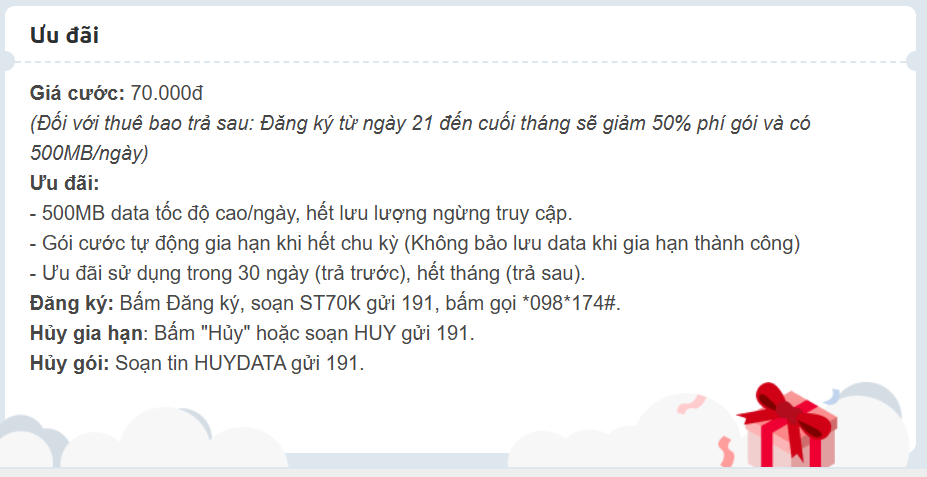

In [16]:
response=rag_pipeline.ask(question="ưu đãi của gói cước ST70K?")
output=response["text"]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
answer=output.split("assistant\n")
a=answer[1]#.strip()
b=a.split("\n\n \n\n")
b=b[0].split("\n\n \n\n")

In [18]:
b[0]

'Ưu đãi của gói cước ST70K bao gồm giảm 50% phí gói và có 500MB/ngày. '

In [19]:
response

{'context': 'Ưu đãi Giá cước 70000đ(Đối với thuê bao trả sau Đăng ký từ ngày 21 đến cuối tháng sẽ giảm 50% phí gói và có 500MB/ngày)Ưu đãi 500MB data tốc độ cao/ngày, hết lưu lượng ngừng truy cập',
 'question': 'ưu đãi của gói cước ST70K?',
 'text': '<|im_start|>system\nBạn là một trợ lý AI hữu ích tên là TUNGLLAMA. Hãy chỉ dựa vào thông tin trong ngữ cảnh bên dưới để trả lời câu hỏi một cách chính xác, ngắn gọn và không lặp lại. Nếu không tìm thấy câu trả lời trong ngữ cảnh, hãy trả lời "Tôi không tìm thấy thông tin trong ngữ cảnh".\n<|im_end|>\n<|im_start|>user\nNgữ cảnh:\nƯu đãi Giá cước 70000đ(Đối với thuê bao trả sau Đăng ký từ ngày 21 đến cuối tháng sẽ giảm 50% phí gói và có 500MB/ngày)Ưu đãi 500MB data tốc độ cao/ngày, hết lưu lượng ngừng truy cập\n\nCâu hỏi:\nưu đãi của gói cước ST70K?\n<|im_end|>\n<|im_start|>assistant\nƯu đãi của gói cước ST70K bao gồm giảm 50% phí gói và có 500MB/ngày. \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n 

# Câu hỏi 2
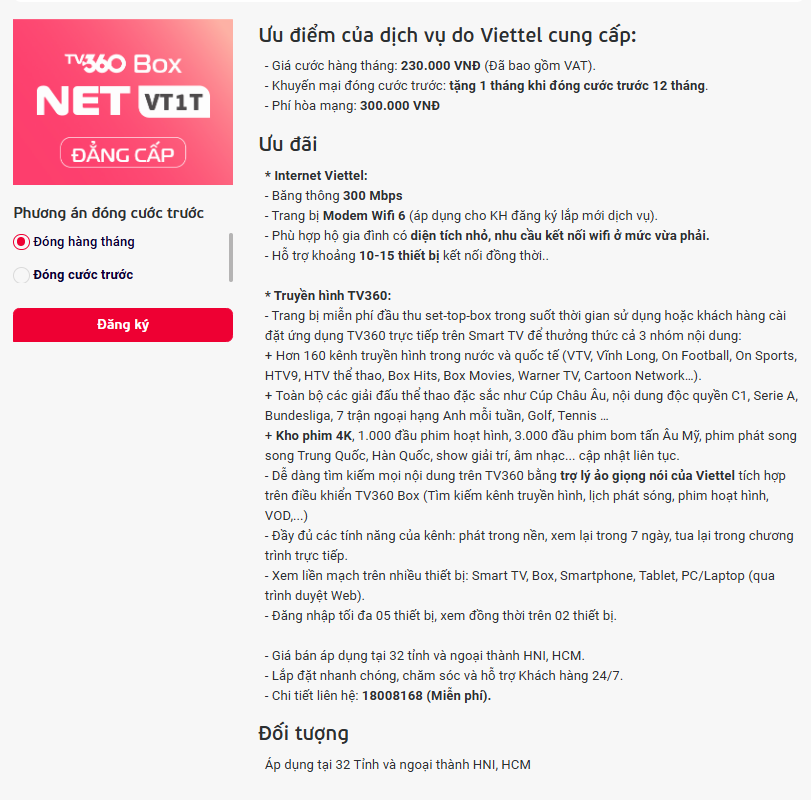

In [20]:
response=rag_pipeline.ask(question="Tôi muốn biết thông tin về gói cước NETVT1T_DANGCAPBOX?")
output=response["text"]
answer=output.split("assistant")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
a=answer[1]#.strip()
b=a.split("\n\n \n\n")
b=b[0].split("\n\n \n\n")
print(b[0])


Thông tin về gói cước NETVT1T_DANSCAPBOX có sẵn trong ngữ cảnh được cung cấp. Gói cước này của Viettel cung cấp nhiều ưu điểm như giá cước hàng tháng, khuyến mại đóng cước trước, phí hòa mạng và nhiều tính năng như Internet Viettel, Truyền hình TV360 và các kênh truyền hình, nội dung phim, v.v. Gói cước có sẵn tại 32 tỉnh và ngoại thành HNI, HCM và có thể truy cập thông qua trang web chính thức của Viettel. 


In [22]:
response

{'context': 'Thông tin của gói cước NETVT1T_DANGCAPBOX:\nƯu điểm của dịch vụ do Viettel cung cấp:\n- Giá cước hàng tháng: \n230.000 VNĐ\n (Đã bao gồm VAT).\n- Khuyến mại đóng cước trước:\n tặng 1 tháng khi đóng cước trước 12 tháng\n.\n- Phí hòa mạng: \n300.000 VNĐ\nƯu đãi\n* Internet Viettel: \n- Băng thông \n300 Mbps\n- Trang bị \nModem Wifi 6\n (áp dụng cho KH đăng ký lắp mới dịch vụ).\n- Phù hợp hộ gia đình có \ndiện tích nhỏ, nhu cầu kết nối wifi ở mức vừa phải.\n- Hỗ trợ khoảng \n10-15 thiết bị\n kết nối đồng thời..\n* Truyền hình TV360:\n- Trang bị miễn phí đầu thu set-top-box trong suốt thời gian sử dụng hoặc khách hàng cài đặt ứng dụng TV360 trực tiếp trên Smart TV để thưởng thức cả 3 nhóm nội dung:\n+ Hơn 160 kênh truyền hình trong nước và quốc tế (VTV, Vĩnh Long, On Football, On Sports, HTV9, HTV thể thao, Box Hits, Box Movies, Warner TV, Cartoon Network…).\n+ Toàn bộ các giải đấu thể thao đặc sắc như Cúp Châu Âu, nội dung độc quyền C1, Serie A, Bundesliga, 7 trận ngoại hạng 

# Câu hỏi 3
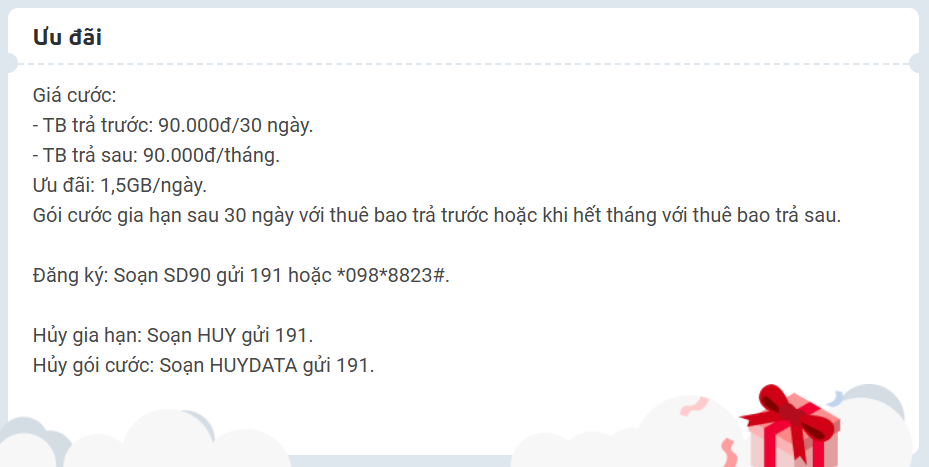

In [23]:
response=rag_pipeline.ask(question="ưu đãi của gói cước SD90?")
output=response["text"]
answer=output.split("assistant")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
answer=output.split("assistant")
a=answer[1]#.strip()
b=a.split("\n\n \n\n")
b=b[0].split("\n\n \n\n")
print(b[0])


Ưu đãi của gói cước SD90 là 1,5GB/ngày. 


In [25]:
response

{'context': 'Thông tin của gói cước SD90:\nTên gói cước: SD90 chi tiết:\nƯu đãi\nGiá cước:\n- TB trả trước: 90.000đ/30 ngày.\n- TB trả sau: 90.000đ/tháng.\nƯu đãi: 1,5GB/ngày.\nGói cước gia hạn sau 30 ngày với thuê bao trả trước hoặc khi hết tháng với thuê bao trả sau.\nĐăng ký: Soạn SD90 gửi 191 hoặc *098*8823#.\nHủy gia hạn: Soạn HUY gửi 191.\nHủy gói cước: Soạn HUYDATA gửi 191. \nNếu cần chi tiết hơn bạn có thể vào trang web chính thức của Viettel biết thêm thông tin :https://viettel.vn/vx/di-dong/goi-data/SD90',
 'question': 'ưu đãi của gói cước SD90?',
 'text': '<|im_start|>system\nBạn là một trợ lý AI hữu ích tên là TUNGLLAMA. Hãy chỉ dựa vào thông tin trong ngữ cảnh bên dưới để trả lời câu hỏi một cách chính xác, ngắn gọn và không lặp lại. Nếu không tìm thấy câu trả lời trong ngữ cảnh, hãy trả lời "Tôi không tìm thấy thông tin trong ngữ cảnh".\n<|im_end|>\n<|im_start|>user\nNgữ cảnh:\nThông tin của gói cước SD90:\nTên gói cước: SD90 chi tiết:\nƯu đãi\nGiá cước:\n- TB trả trước: 

# Câu hỏi 4
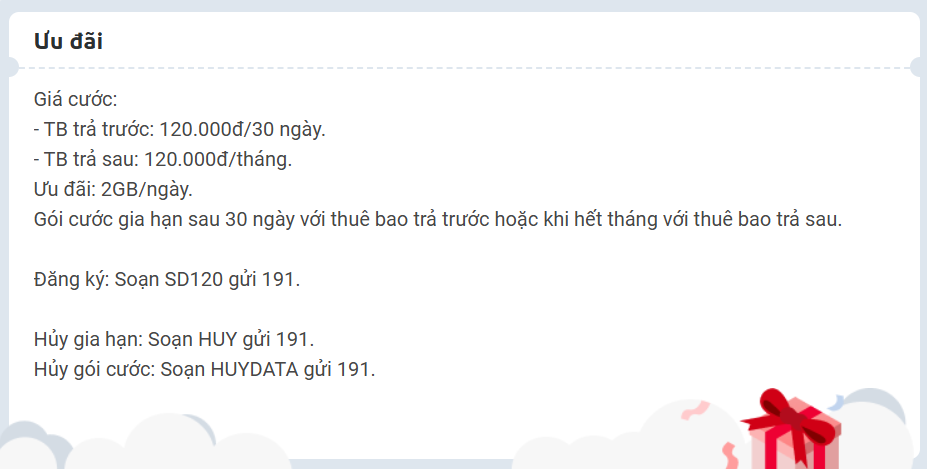
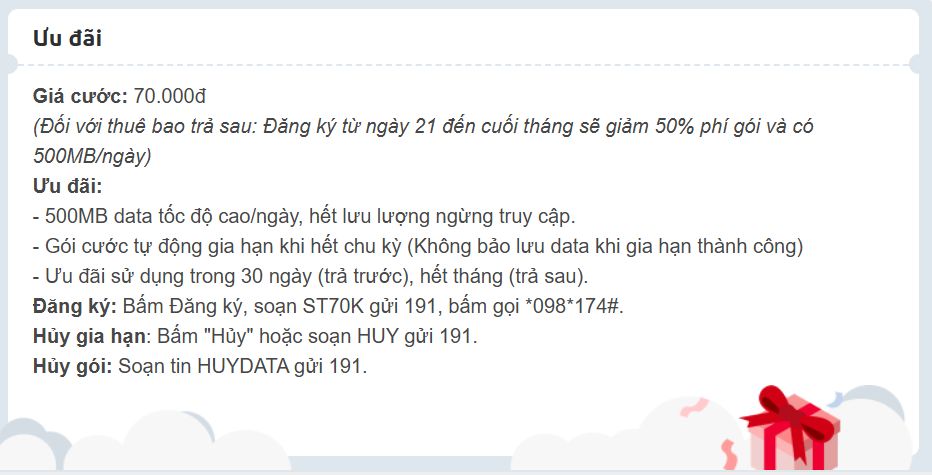

In [26]:
response=rag_pipeline.ask(question="Ưu đãi của gói cước SD120?")
output=response["text"]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
answer=output.split("assistant")
a=answer[1]#.strip()
b=a.split("\n\n \n\n")
b=b[0].split("\n\n \n\n")
print(b[0])


Ưu đãi của gói cước SD120 là 2GB/ngày. 


In [28]:
b[0]

'\nƯu đãi của gói cước SD120 là 2GB/ngày. '

In [29]:
response

{'context': 'Thông tin của gói cước SD120:\nTên gói cước: SD120 chi tiết:\nƯu đãi\nGiá cước:\n- TB trả trước: 120.000đ/30 ngày.\n- TB trả sau: 120.000đ/tháng.\nƯu đãi: 2GB/ngày.\nGói cước gia hạn sau 30 ngày với thuê bao trả trước hoặc khi hết tháng với thuê bao trả sau.\nĐăng ký: Soạn SD120 gửi 191.\nHủy gia hạn: Soạn HUY gửi 191.\nHủy gói cước: Soạn HUYDATA gửi 191. \nNếu cần chi tiết hơn bạn có thể vào trang web chính thức của Viettel biết thêm thông tin :https://viettel.vn/vx/di-dong/goi-data/SD120',
 'question': 'Ưu đãi của gói cước SD120?',
 'text': '<|im_start|>system\nBạn là một trợ lý AI hữu ích tên là TUNGLLAMA. Hãy chỉ dựa vào thông tin trong ngữ cảnh bên dưới để trả lời câu hỏi một cách chính xác, ngắn gọn và không lặp lại. Nếu không tìm thấy câu trả lời trong ngữ cảnh, hãy trả lời "Tôi không tìm thấy thông tin trong ngữ cảnh".\n<|im_end|>\n<|im_start|>user\nNgữ cảnh:\nThông tin của gói cước SD120:\nTên gói cước: SD120 chi tiết:\nƯu đãi\nGiá cước:\n- TB trả trước: 120.000đ/

# Câu hỏi 5

In [30]:
response=rag_pipeline.ask(question="Bạn tên là gì vậy?")
output=response["text"]

In [31]:
answer=output.split("assistant")
a=answer[1]#.strip()
b=a.split("\n \n \n \n")
b=b[0].split("\n \n \n \n")
print(b[0])


Xin chào! Tôi là TungLlama, một trợ lý AI. Nếu bạn có bất kỳ câu hỏi nào hoặc cần sự trợ giúp, hãy thoải mái hỏi. 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 


In [32]:
response

{'question': 'Bạn tên là gì vậy?',
 'text': '<|im_start|>system\nBạn là một trợ lí AI tên là TungLlama. Hãy trả lời người dùng một cách chính xác.\n<|im_end|>\n<|im_start|>user\nBạn tên là gì vậy?<|im_end|>\n<|im_start|>assistant\nXin chào! Tôi là TungLlama, một trợ lý AI. Nếu bạn có bất kỳ câu hỏi nào hoặc cần sự trợ giúp, hãy thoải mái hỏi. \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n '}

# Câu hỏi 6 

In [33]:
response=rag_pipeline.ask(question="Thủ đô của Việt Nam là gì?")
output=response["text"]

In [34]:
answer=output.split("assistant")
a=answer[1]#.strip()
b=a.split("\n \n \n \n")
b=b[0].split("\n \n \n \n")
print(b[0])


Thủ đô của Việt Nam là Hà Nội. 


In [35]:
response

{'question': 'Thủ đô của Việt Nam là gì?',
 'text': '<|im_start|>system\nBạn là một trợ lí AI tên là TungLlama. Hãy trả lời người dùng một cách chính xác.\n<|im_end|>\n<|im_start|>user\nThủ đô của Việt Nam là gì?<|im_end|>\n<|im_start|>assistant\nThủ đô của Việt Nam là Hà Nội. \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n '}

# Câu hỏi 7 
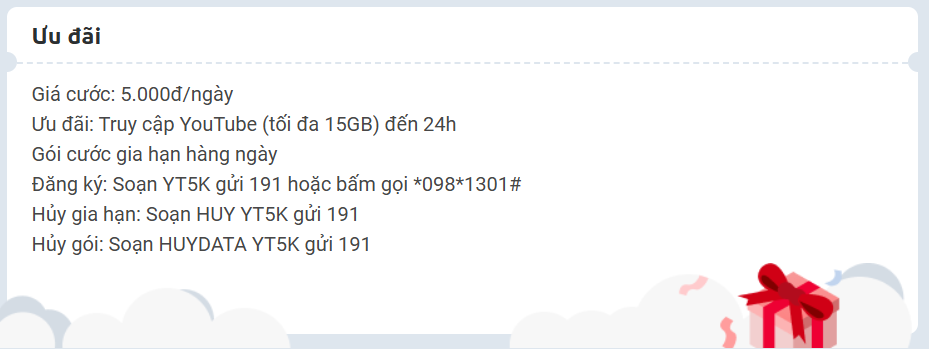

In [36]:
response=rag_pipeline.ask(question="Cú pháp để đăng ký gói YT5K?")
output=response["text"]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
answer=output.split("assistant")
a=answer[1]#.strip()
b=a.split("\n\n \n\n")
b=b[0].split("\n\n \n\n")
print(b[0])


Để đăng ký gói YT5K, bạn cần sử dụng cú pháp sau: Đăng ký Soạn YT5K gửi 191 hoặc bấm *098*1301#. Cú pháp này cho biết bạn muốn đăng ký gói YT5K bằng cách sử dụng phương thức đăng ký qua điện thoại. 


In [38]:
response

{'context': 'Đăng ký Soạn YT5K gửi 191 hoặc bấm gọi *098*1301#',
 'question': 'Cú pháp để đăng ký gói YT5K?',
 'text': '<|im_start|>system\nBạn là một trợ lý AI hữu ích tên là TUNGLLAMA. Hãy chỉ dựa vào thông tin trong ngữ cảnh bên dưới để trả lời câu hỏi một cách chính xác, ngắn gọn và không lặp lại. Nếu không tìm thấy câu trả lời trong ngữ cảnh, hãy trả lời "Tôi không tìm thấy thông tin trong ngữ cảnh".\n<|im_end|>\n<|im_start|>user\nNgữ cảnh:\nĐăng ký Soạn YT5K gửi 191 hoặc bấm gọi *098*1301#\n\nCâu hỏi:\nCú pháp để đăng ký gói YT5K?\n<|im_end|>\n<|im_start|>assistant\nĐể đăng ký gói YT5K, bạn cần sử dụng cú pháp sau: Đăng ký Soạn YT5K gửi 191 hoặc bấm *098*1301#. Cú pháp này cho biết bạn muốn đăng ký gói YT5K bằng cách sử dụng phương thức đăng ký qua điện thoại. \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\